## Amplitude analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as convolve
from scipy.stats import norm, chi2, skewnorm, gamma, laplace, lognorm, loggamma, t

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
include_wls = False

In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
def get_template(frequency,n_period, binning):
    frequency, binning = frequency.value, binning.to(u.s).value
    duration = 1/frequency * n_period
    x = np.arange(0,duration+binning,binning)
    template = np.sin(frequency*x*2*np.pi)
    return x, template

In [6]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [7]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

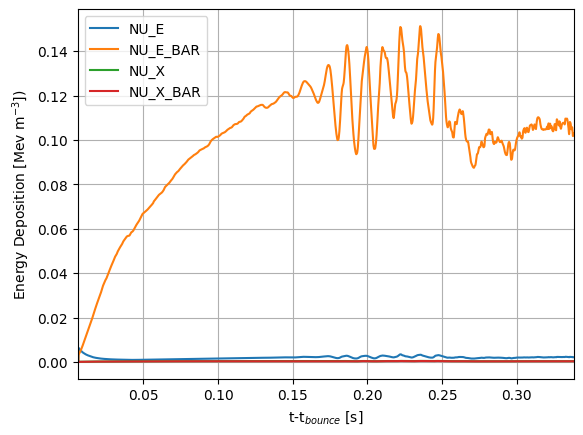

In [8]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0.006, 0.338))
ax.grid()

In [9]:
dt = 1 * u.ms
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [10]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [11]:
def signal_processing(sim, dt, distance, trials, background_bins=100, dist=gamma,
                      return_raw=False,
                      return_deviation=False, 
                      return_percentage=False,
                      return_correlation=False,
                      return_max_correlation=False,
                      return_dist=False,
                      return_background_trials=False,
                      return_significance=False):
         
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])
    
    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2

    # background subtraction Sb: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    
    # deviation Sd: signal + background - average background - average signal
    Sd_ic86 = Sb_ic86 - sa_ic86
    Sd_gen2 = Sb_gen2 - sa_gen2

    # percentage deviation Sp: (signal + background - average background)/average signal
    Sp_ic86 = (Sb_ic86/sa_ic86)-1
    Sp_gen2 = (Sb_gen2/sa_gen2)-1
        
    # analysis window mask
    tmask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    
    # generate template of same shape in dimension 0 as data to convolve with
    t_template, template = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
    template = np.repeat(template,repeats=trials)
    template = template.reshape(trials,-1)

    # cross correlation in analysis window, negative sign applied such that scipy.signal.fftconvolve returns same 
    # sign than np.correlate
    Sc_ic86 = -convolve(Sp_ic86[:,tmask], template, mode='same', axes=-1)
    Sc_gen2 = -convolve(Sp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Sm_ic86 = np.nanmax(Sc_ic86, axis=-1)
    Sm_gen2 = np.nanmax(Sc_gen2, axis=-1)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Sb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Sd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    # cross correlation in analysis window
    Bc_ic86 = -convolve(Bp_ic86[:,tmask], template, mode='same', axes=-1)
    Bc_gen2 = -convolve(Bp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Bm_ic86 = np.nanmax(Bc_ic86, axis=-1)
    Bm_gen2 = np.nanmax(Bc_gen2, axis=-1)
    
    # computed to get the range of the histogram fixed for all four histograms for a given distance
    comb_data = np.hstack((Sm_ic86, Bm_ic86, Sm_gen2, Bm_gen2))
    rmin, rmax = np.min(comb_data), np.max(comb_data)

    # normalized histogram = PDF
    Spdf_ic86, bins = np.histogram(Sm_ic86, bins = 100, density=True)#, range = [rmin,rmax])
    Bpdf_ic86, bins = np.histogram(Bm_ic86, bins = background_bins, density=True)#, range = [rmin,rmax])
    Spdf_gen2, bins = np.histogram(Sm_gen2, bins = 100, density=True)#, range = [rmin,rmax])
    Bpdf_gen2, bins = np.histogram(Bm_gen2, bins = background_bins, density=True)#, range = [rmin,rmax])

    # histgram x values
    x = (bins[1:]+bins[:-1])/2
    
    # cumulated histogram = CDF
    Scdf_gen2 = np.cumsum(Spdf_gen2)/np.sum(Spdf_gen2)
    Bcdf_gen2 = np.cumsum(Bpdf_gen2)/np.sum(Bpdf_gen2)
    Scdf_ic86 = np.cumsum(Spdf_ic86)/np.sum(Spdf_ic86)
    Bcdf_ic86 = np.cumsum(Bpdf_ic86)/np.sum(Bpdf_ic86)
    
    # determine quantiles of background distribution
    significances = np.array([1,2,3,4,5])
    q_gen2, q_ic86 = [], []
    for sig in significances:
        cl = norm.cdf(sig)-norm.cdf(-sig)
        q_gen2.append(np.quantile(Bm_gen2, cl))
        q_ic86.append(np.quantile(Bm_ic86, cl))
    Q_gen2 = np.array(q_gen2)
    Q_ic86 = np.array(q_ic86)
    
    fit_param_gen2 = dist.fit(Bm_gen2)
    fit_param_ic86 = dist.fit(Bm_ic86)

    fit_gen2 = dist(*fit_param_gen2)
    fit_ic86 = dist(*fit_param_ic86)

    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_deviation:
        return t, Sd_gen2, Sd_ic86, Bd_gen2, Bd_ic86
    
    if return_percentage:
        return t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_correlation:
        return t[tmask], Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86
    
    if return_max_correlation:
        return t, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86
    
    if return_dist:
        return x, Spdf_gen2, Bpdf_gen2, Spdf_ic86, Bpdf_ic86, Scdf_gen2, Bcdf_gen2, Scdf_ic86, Bcdf_ic86
    
    if return_background_trials:
        return x, Bpdf_gen2, Bpdf_ic86, Bcdf_gen2, Bcdf_ic86, significances, Q_gen2, Q_ic86, fit_gen2, fit_ic86


    if return_significance:
        return Z_gen2, Z_ic86

In [12]:
def background_trials(sim, dt, distance, trials, dist=gamma):
         
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3')
    signal_len=len(s_i3)
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=signal_len*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=signal_len*trials)
    b_md = sim.detector.md_bg(dt=dt, size=signal_len*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,signal_len)
    b_dc = b_dc.reshape(trials,signal_len)
    b_md = b_md.reshape(trials,signal_len)
    
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

        
    # analysis window mask
    tmask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    
    # generate template of same shape in dimension 0 as data to convolve with
    t_template, template = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
    template = np.repeat(template,repeats=trials)
    template = template.reshape(trials,-1)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Sb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Sd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    # cross correlation in analysis window
    Bc_ic86 = -convolve(Bp_ic86[:,tmask], template, mode='same', axes=-1)
    Bc_gen2 = -convolve(Bp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Bm_ic86 = np.nanmax(Bc_ic86, axis=-1)
    Bm_gen2 = np.nanmax(Bc_gen2, axis=-1)
    
    
    fit_param_gen2 = dist.fit(Bm_gen2)
    fit_param_ic86 = dist.fit(Bm_ic86)

    fit_gen2 = dist(*fit_param_gen2)
    fit_ic86 = dist(*fit_param_ic86)


    return t, Bm_gen2, Bm_ic86, fit_gen2, fit_ic86

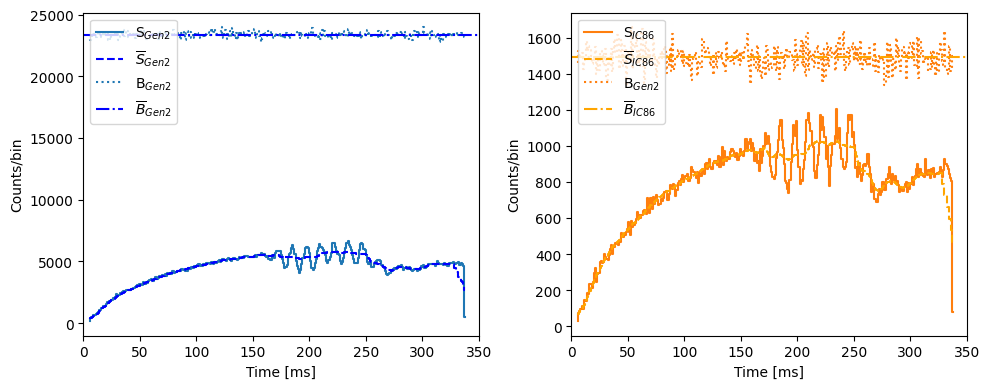

In [68]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, return_raw=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,s_gen2[0], color = 'C0', ls = '-', label=r'S$_{Gen2}$')
ax[0].step(t,sa_gen2, color = 'blue', ls = '--', label=r'$\overline{S}_{Gen2}$')
ax[0].step(t,b_gen2[0], color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].axhline(ba_gen2, color = 'blue', ls = '-.', label=r'$\overline{B}_{Gen2}$')
ax[1].step(t,s_ic86[0], color = 'C1', ls = '-', label=r'S$_{IC86}$')
ax[1].step(t,sa_ic86, color = 'orange', ls = '--', label=r'$\overline{S}_{IC86}$')
ax[1].step(t,b_ic86[0], color = 'C1', ls = ':', label=r'B$_{Gen2}$')
ax[1].axhline(ba_ic86, color = 'orange', ls = '-.', label=r'$\overline{B}_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

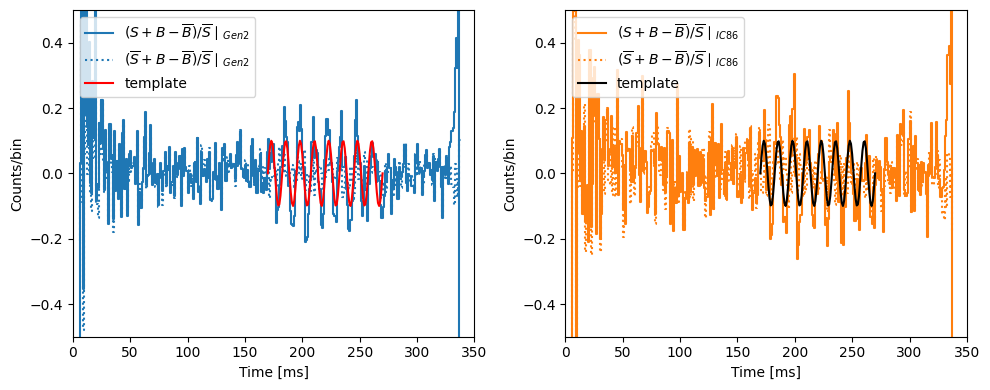

In [91]:
t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_percentage=True)
tt, ty = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
tt = tt * u.s.to(u.ms)+170
ty /= 10
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sp_gen2[0], color = 'C0', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].step(t,Bp_gen2[0], color = 'C0', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].plot(tt,ty, color='red', label='template')
ax[1].step(t,Sp_ic86[0], color = 'C1', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].step(t,Bp_ic86[0], color = 'C1', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].plot(tt,ty, color='black', label='template')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].set_ylim(-0.5,0.5)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].set_ylim(-0.5,0.5)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

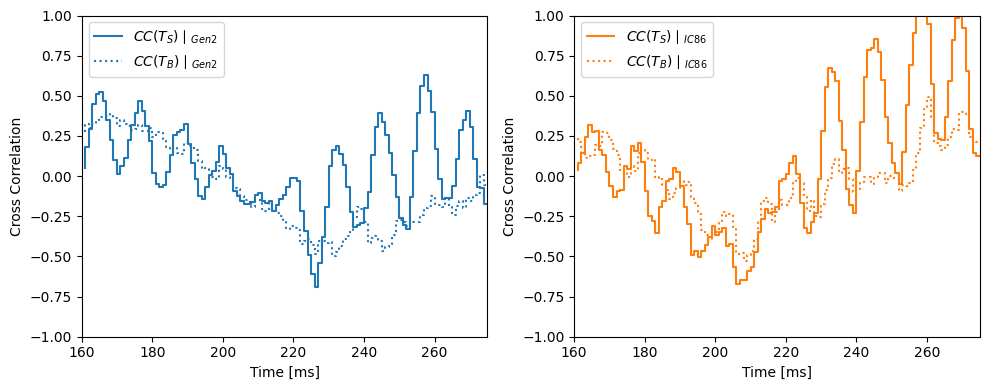

In [88]:
t, Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_correlation=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sc_gen2[0], color = 'C0', ls = '-', label=r'$CC(T_S)\mid_{Gen2}$')
ax[0].step(t,Bc_gen2[0], color = 'C0', ls = ':', label=r'$CC(T_B)\mid_{Gen2}$')
ax[1].step(t,Sc_ic86[0], color = 'C1', ls = '-', label=r'$CC(T_S)\mid_{IC86}$')
ax[1].step(t,Bc_ic86[0], color = 'C1', ls = ':', label=r'$CC(T_B)\mid_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Cross Correlation')
ax[0].set_xlim(160,275)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Cross Correlation')
ax[1].set_xlim(160,275)
ax[1].set_ylim(-1,1)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

In [97]:
x, Bm_gen2, Bm_ic86, fit_gen2, fit_ic86 = background_trials(sim, dt=dt, distance=10*u.kpc, trials=100000, dist=skewnorm)

In [98]:
Bpdf_gen2, bin_gen2 = np.histogram(Bm_gen2, bins = 'auto', density=True)#, range = [rmin,rmax])
Bpdf_ic86, bin_ic86 = np.histogram(Bm_ic86, bins = 'auto', density=True)#, range = [rmin,rmax])
x_gen2 = (bin_gen2[1:]+bin_gen2[:-1])/2
x_ic86 = (bin_ic86[1:]+bin_ic86[:-1])/2


Bcdf_gen2 = np.cumsum(Bpdf_gen2)/np.sum(Bpdf_gen2)
Bcdf_ic86 = np.cumsum(Bpdf_ic86)/np.sum(Bpdf_ic86)

significances = np.array([1,2,3,4,5])
qh_gen2, qh_ic86 = [], [] # quantiles from histogram
qf_gen2, qf_ic86 = [], [] # quantiles from fit

for sig in significances:
    cl = norm.cdf(sig)-norm.cdf(-sig)
    qf_gen2.append(fit_gen2.ppf(cl))
    qf_ic86.append(fit_ic86.ppf(cl))
    qh_gen2.append(np.quantile(Bm_gen2, cl))
    qh_ic86.append(np.quantile(Bm_ic86, cl))
Qh_gen2 = np.array(qh_gen2)
Qh_ic86 = np.array(qh_ic86)
Qf_gen2 = np.array(qf_gen2)
Qf_ic86 = np.array(qf_ic86)

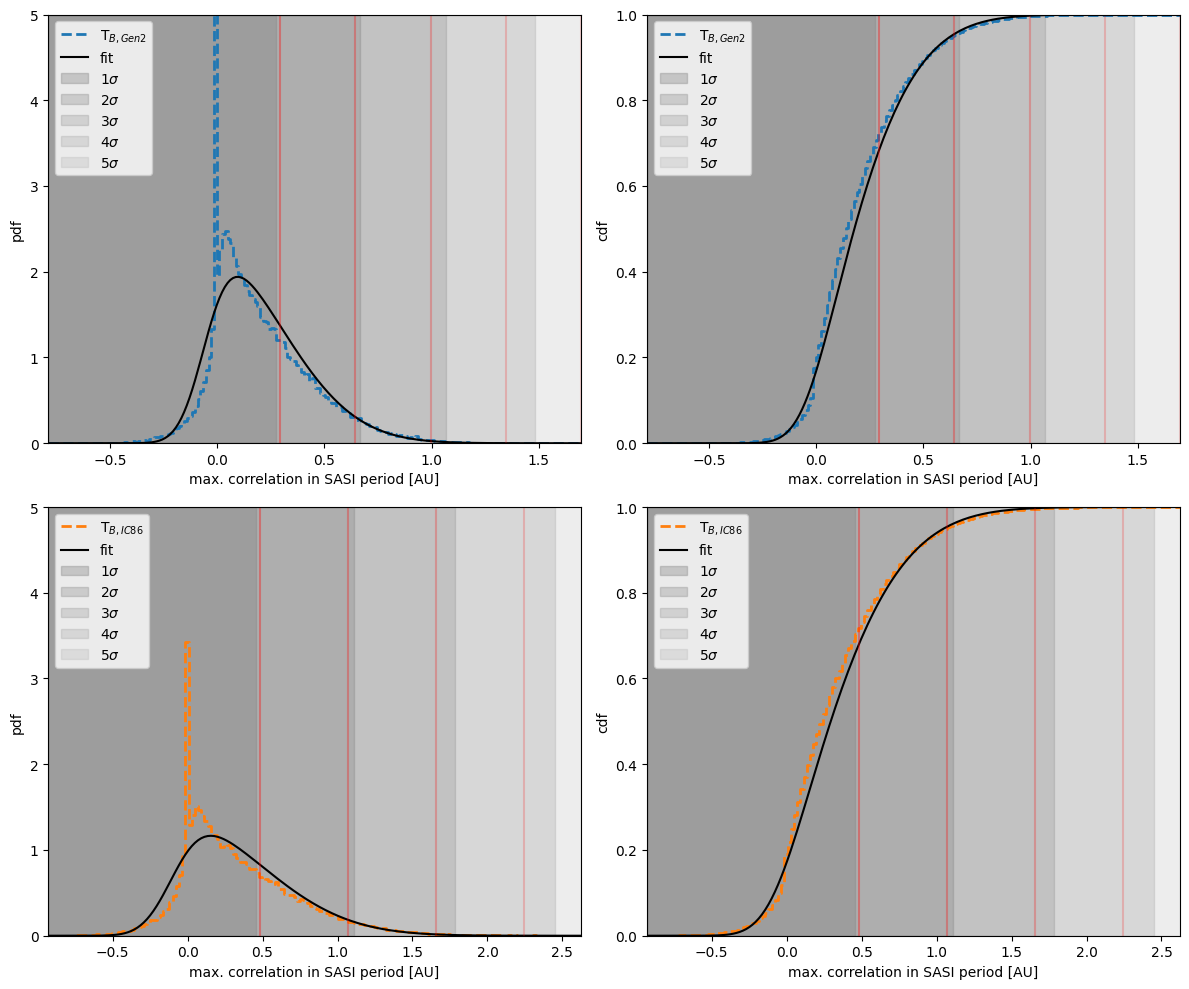

In [99]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax = ax.ravel()

ax[0].step(x_gen2, Bpdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$', lw = 2)
ax[0].plot(x_gen2, fit_gen2.pdf(x_gen2), color = 'k', label = 'fit')
ax[1].step(x_gen2, Bcdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$', lw = 2)
ax[1].plot(x_gen2, fit_gen2.cdf(x_gen2), color = 'k', label = 'fit')
ax[2].step(x_ic86, Bpdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$', lw = 2)
ax[2].plot(x_ic86, fit_ic86.pdf(x_ic86), color = 'k', label = 'fit')
ax[3].step(x_ic86, Bcdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$', lw = 2)
ax[3].plot(x_ic86, fit_ic86.cdf(x_ic86), color = 'k', label = 'fit')


for j in range(4):
    if j < 2:
        qh = Qh_gen2
        qf = Qf_gen2
        xmin = x_gen2.min()
        xmax = x_gen2.max()
    else:
        qh = Qh_ic86
        qf = Qf_ic86
        xmin = x_ic86.min()
        xmax = x_ic86.max()


    for i, qi in enumerate(qh):
        ax[j].axvspan(xmin, qh[i], label = r'{:d}$\sigma$'.format(significances[i]), alpha = (1-0.15*i)*0.35, color = 'grey')
        ax[j].axvline(qf[i],0,5, alpha = (1-0.15*i)*0.35, color = 'red')

    ax[j].set_xlabel('max. correlation in SASI period [AU]')
    ax[j].legend()
    ax[j].set_xlim(xmin,xmax)
    if j%2==0:
        ax[j].set_ylabel('pdf')
        ax[j].set_ylim(0,5)
        
    else:
        ax[j].set_ylabel('cdf')
        ax[j].set_ylim(0,1)

plt.tight_layout()

In [61]:
Qf_gen2

array([0.04136564, 0.09123269, 0.14109924, 0.19096578, 0.24083233])

In [64]:
plt.axvline?